# Axisymmetric formulation for elastic structures of revolution

In this numerical tour, we will deal with axisymmetric problems of elastic solids. We will consider a solid of revolution around a fixed axis $(Oz)$, the loading, boundary conditions and material properties being also invariant with respect to a rotation along the symmetry axis. The solid cross-section in a plane $\theta=\text{cst}$ will be represented by a two-dimensional domain $\omega$ for which the first spatial variable (`x[0]` in FEniCS) will represent the radial coordinate $r$ whereas the second spatial variable will denote the axial variable $z$.

## Problem position

We will investigate here the case of a hollow hemisphere of inner (resp. outer) radius $R_i$ (resp. $R_e$). Due to the revolution symmetry, the 2D cross-section corresponds to a quarter of a hollow cylinder.

In [64]:
from __future__ import print_function

from mpi4py import MPI
from dolfinx.io import XDMFFile, gmshio
from dolfinx.mesh import meshtags_from_entities
from dolfinx.fem.petsc import LinearProblem
from dolfinx import fem, plot
from dolfinx import default_scalar_type

import ufl
import matplotlib.pyplot as plt
import numpy as np

try:
    import gmsh
except ImportError:
    print("This demo requires gmsh to be installed")
    exit(0)

Re = 11.
Ri = 9.

def gmsh_hollow_circle(model: gmsh.model, name: str, option: gmsh.option) -> gmsh.model:
    model.add(name)
    model.setCurrent(name)

    # Create outer and inner circles
    outer_circle = model.occ.addDisk(0, 0, 0, Re, Re)
    inner_circle = model.occ.addDisk(0, 0, 0, Ri, Ri)
    
    # Cut the inner circle from the outer circle to create a hollow circle
    hollow_circle = model.occ.cut([(2, outer_circle)], [(2, inner_circle)])[0]
    model.occ.synchronize()

    # Add physical groups
    gdim = 2
    model.addPhysicalGroup(gdim, [hollow_circle[0][1]], tag=1)
    model.setPhysicalName(2, 1, "Hollow circle")
    
    boundary_entities = model.getEntities(2)
    boundary_ids = [entity[1] for entity in boundary_entities if entity[1] != hollow_circle[0][1]]
    model.addPhysicalGroup(2, boundary_ids, tag=2)
    model.setPhysicalName(2, 2, "Boundary")

    option.setNumber("Mesh.CharacteristicLengthMin", 0.5)
    option.setNumber("Mesh.CharacteristicLengthMax", 0.5)
    model.mesh.generate(gdim)
    return model

def create_mesh(comm: MPI.Comm, model: gmsh.model, name: str, filename: str, mode: str):
    msh, ct, ft = gmshio.model_to_mesh(model, comm, rank=0)
    msh.name = name
    ct.name = f"{msh.name}_cells"
    ft.name = f"{msh.name}_facets"

    tdim = msh.topology.dim
    fdim = tdim - 1

    with XDMFFile(msh.comm, filename, mode) as file:
        msh.topology.create_connectivity(fdim, tdim)
        file.write_mesh(msh)
        file.write_meshtags(
            ct, msh.geometry, geometry_xpath=f"/Xdmf/Domain/Grid[@Name='{msh.name}']/Geometry"
        )
        file.write_meshtags(
            ft, msh.geometry, geometry_xpath=f"/Xdmf/Domain/Grid[@Name='{msh.name}']/Geometry"
        )

# Initialize Gmsh
gmsh.initialize()
gmsh.option.setNumber("General.Terminal", 0)

# Create model
model = gmsh.model()
option = gmsh.option()

# Create a Gmsh model of a 2D hollow circle
model = gmsh_hollow_circle(model, "HollowCircle", option)
model.setCurrent("HollowCircle")

# Create a DOLFINx mesh from the Gmsh model and save to an XDMF file
create_mesh(MPI.COMM_SELF, model, "hollow_circle", "out_gmsh/hollow_circle.xdmf", "w")

# We can use this to clear all the model data:
# gmsh.clear()
# gmsh.finalize()

# The generated mesh can be visualized using ParaView.
gdim = 2
gmsh_model_rank = 0
mesh_comm = MPI.COMM_WORLD

domain, cell_markers, facet_markers = gmshio.model_to_mesh(gmsh.model, mesh_comm, gmsh_model_rank, gdim=gdim)

# Material properties
E = 1e6 # Pa
nu = 0.33
G = E / (2*(1+nu))
lambda_ = nu * E /((1+nu)*(1-2*nu))
mu = G

x = ufl.SpatialCoordinate(domain)

# Functional spaces
V = fem.functionspace(domain, ("CG", 2, (domain.geometry.dim,)))

# Test and trial functions
ds = ufl.Measure("ds", domain=domain)
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)

p = fem.Constant(domain, default_scalar_type(300000.0))

def on_boundary(x):
    return np.isclose(np.sqrt(x[0]**2 + x[1]**2), Re)

boundary_dofs = fem.locate_dofs_geometrical(V, on_boundary)

n = ufl.FacetNormal(domain)

def sigma(u, lambda_, mu):
    return lambda_ * ufl.nabla_div(u) * ufl.Identity(len(u)) + 2*mu*epsilon(u)

def epsilon(u):
    return ufl.sym(ufl.grad(u))

a = ufl.inner(sigma(u, lambda_, mu), epsilon(v)) * ufl.dx
L = ufl.inner(-p*n, v) * x[0] * ds

# Define the boundary condition
u_bc = np.array((0,) * domain.geometry.dim, dtype=default_scalar_type)
boundary_dofs = fem.locate_dofs_geometrical(V, on_boundary)
bc = fem.dirichletbc(u_bc, boundary_dofs, V)

problem = LinearProblem(a, L, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})

uh = problem.solve()

## Definition of axisymmetric strains

For axisymmetric conditions, the unkown displacement field is of the form:

$$\begin{equation}
\boldsymbol{u} = u_r(r,z)\boldsymbol{e}_r + u_z(r,z)\boldsymbol{e}_z
\end{equation}$$

As a result, we will work with a standard VectorFunctionSpace of dimension 2. The associated strain components are however given by:

$$\begin{equation}
\boldsymbol{\varepsilon} = \begin{bmatrix} \partial_r u_r & 0 & (\partial_z u_r + \partial_r u_z)/2 \\ 
0 & u_r/r & 0 \\
(\partial_z u_r + \partial_r u_z)/2 & 0 & \partial_z u_z\end{bmatrix}_{(\boldsymbol{e}_r,\boldsymbol{e}_\theta,\boldsymbol{e}_z)}
\end{equation}$$

The previous relation involves explicitly the radial variable $r$, which can be obtained from the SpatialCoordinate `x[0]`, the strain-displacement relation is then defined explicitly in the `eps` function.

> **Note**: we could also express the strain components in the form of a vector of size 4 in alternative of the 3D tensor representation implemented below.

## Resolution

The rest of the formulation is similar to the 2D elastic case with a small difference in the integration measure. Indeed, the virtual work principle reads as:

$$\begin{equation}
 \text{Find } \boldsymbol{u}\in V \text{ s.t. } \int_{\Omega}
 \boldsymbol{\sigma}(\boldsymbol{u}):\boldsymbol{\varepsilon}(\boldsymbol{v}) d\Omega
 = \int_{\partial \Omega_T} \boldsymbol{T}\cdot\boldsymbol{v}  dS \quad \forall\boldsymbol{v} \in V
 \end{equation}$$
 
where $\boldsymbol{T}$ is the imposed traction on some part $\partial \Omega_T$ of the domain boundary.

In axisymmetric conditions, the full 3D domain $\Omega$ can be decomposed as $\Omega = \omega \times [0;2\pi]$ where the interval represents the $\theta$ variable. The integration measures therefore reduce to $d\Omega = d\omega\cdot(rd\theta)$ and $dS = ds\cdot(rd\theta)$ where $dS$ is the surface integration measure on the 3D domain $\Omega$ and $ds$ its counterpart on the cross-section boundary $\partial \omega$. Exploiting the invariance of all fields with respect to $\theta$, the previous virtual work principle is reformulated on the cross-section only as follows:

$$\begin{equation}
 \text{Find } \boldsymbol{u}\in V \text{ s.t. } \int_{\omega}
 \boldsymbol{\sigma}(\boldsymbol{u}):\boldsymbol{\varepsilon}(\boldsymbol{v}) rd\omega
 = \int_{\partial \omega_T} \boldsymbol{T}\cdot\boldsymbol{v}  rds \quad \forall\boldsymbol{v} \in V
 \end{equation}$$
 
where the $2\pi$ constants arising from the integration on $\theta$ have been cancelled on both sides. As a result, the bilinear and linear form are similar to the plane 2D case with the exception of the additional $r$ term in the integration measures.

The final formulation is therefore pretty straightforward. Since a uniform pressure loading is applied on the outer boundary, we will also need the exterior normal vector to define the work of external forces form.

First, smooth contact conditions are assumed on both $r=0$ (`Left`) and $z=0$ (`Bottom`) boundaries. For this specific case, the solution corresponds to the classical hollow sphere under external pressure with a purely radial displacement:

$$\begin{equation}
u_r(r) = -\dfrac{R_e^3}{R_e^3-R_i^3}\left((1 − 2\nu)r + (1 + \nu)\dfrac{R_i^3}{2r^2}\right)\dfrac{p}{E},
\quad u_z=0
\end{equation}$$

The second loading case corresponds to a fully clamped condition on $z=0$, the vertical boundary remaining in smooth contact.

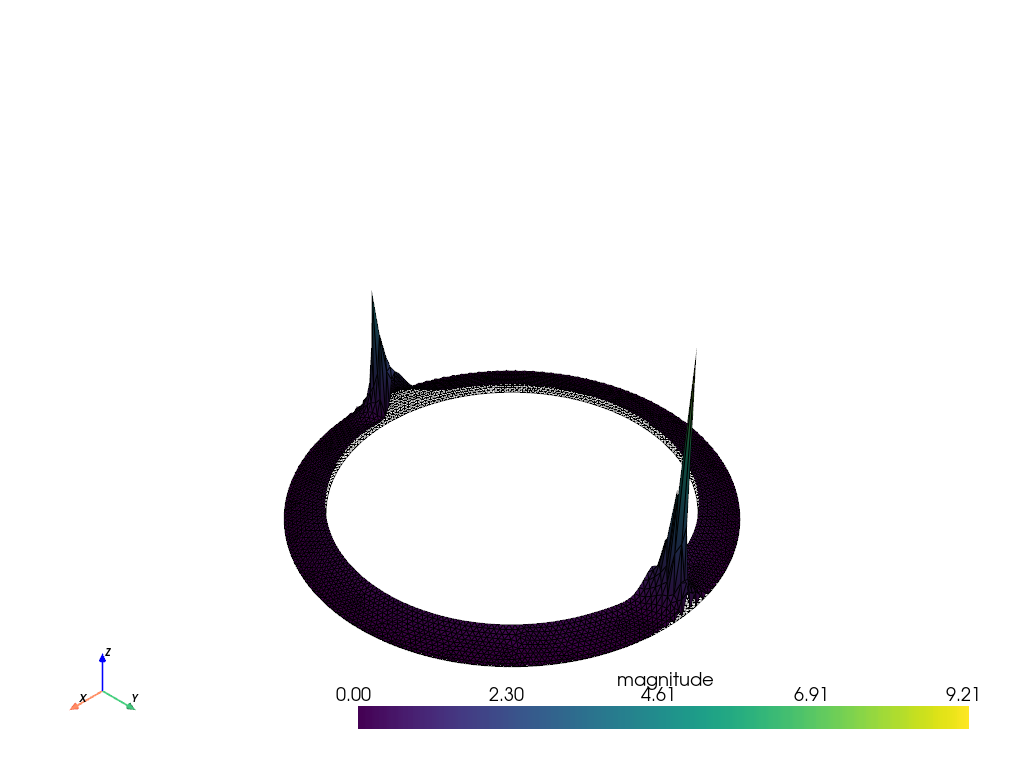

In [65]:
import pyvista
from dolfinx.plot import vtk_mesh
import numpy as np

# Initialize the pyvista plotting environment
pyvista.start_xvfb()  # Ensure this is necessary for your environment

# Create a pyvista plotter object
plotter = pyvista.Plotter()

# Extract mesh data from DOLFINx
topology, cell_types, geometry = vtk_mesh(V)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

# Check the length and dimensions of uh.x.array
num_points = geometry.shape[0]
if len(uh.x.array) != num_points * 2:
    raise ValueError(f"Length of uh.x.array ({len(uh.x.array)}) does not match expected number of components ({num_points * 2})")

# Reshape the array for 2D vectors
vector_data = uh.x.array.reshape((num_points, 2))

# Compute magnitudes of the vectors for warping
magnitude = np.sqrt(np.sum(vector_data**2, axis=1))

# Add vector magnitudes to the grid as scalar data
grid.point_data["magnitude"] = magnitude

# Warp the grid by scalar magnitude
warped = grid.warp_by_scalar("magnitude", factor=1.5)

# Add mesh to the plotter
plotter.add_mesh(grid, style="wireframe", color="k")
plotter.add_mesh(warped, show_edges=True)

# Show plot
plotter.show_axes()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    figure_as_array = plotter.screenshot("deflection.png")
